# Preprocess

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the Dataset

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('./airline_passengers.csv', header=0)#, parse_dates=['Month'])

## 1. Inspect the Data

In [ ]:
# 1. Data Inspection

# Summary statistics of the dataset
print("Summary Statistics:")
print(df.describe(), "\n")
# Inspect the first few rows, dataset columns(features), data types, and shape
print("Dataset Overview:")
print(df.head(), "\n")
print("Dataset Columns:", df.columns)
print("Dataset Data Types:", df.dtypes)
print("Dataset Shape:", df.shape)

Summary Statistics:
       Passengers
count  166.000000
mean   280.650602
std    114.890771
min    104.000000
25%    191.000000
50%    264.000000
75%    355.750000
max    622.000000 

Dataset Overview:
     Month  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05         NaN 

Dataset Columns: Index(['Month', 'Passengers'], dtype='object')
Dataset Data Types: Month          object
Passengers    float64
dtype: object
Dataset Shape: (174, 2)


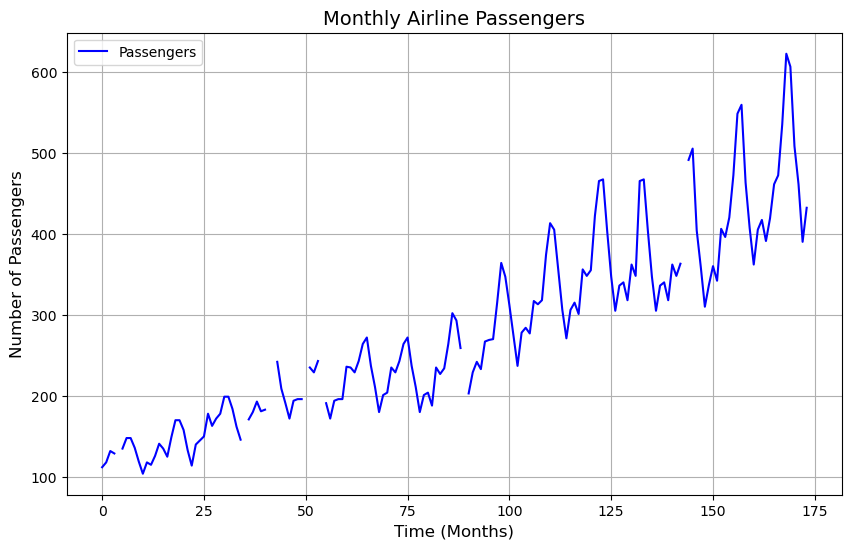

In [ ]:
# Plot the original 'Passengers' data
plt.figure(figsize=(10, 6))
plt.plot(df['Passengers'], label='Passengers', color='b')

# Set title and labels
plt.title('Monthly Airline Passengers', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Show gridlines
plt.grid(True)
# Show legend
plt.legend()
# Display the plot
plt.show()

## 2. Remove Duplicates

In [ ]:
# Check for duplicate rows in the dataset
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    # Remove duplicate rows
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows.")
else:
    print("No duplicates found.")

Number of duplicate rows: 28
Removed 28 duplicate rows.


## 3. Handle Missing Values

In [ ]:
# TODO: Check for missing values in each column
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100

print(f"Missing values per column:\n{missing_values}")
print(f"Percentage of missing values per column:\n{missing_values_percentage}\n")

if missing_values.sum() > 0:
    # TODO: Impute missing values with the column mean (simple imputation strategy)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    print("Missing values have been imputed with the column mean.")
else:
    print("No missing values found.")

Missing values per column:
Month         0
Passengers    8
dtype: int64
Percentage of missing values per column:
Month         0.000000
Passengers    5.479452
dtype: float64

Missing values have been imputed with the column mean.


## 4. Train/Val/Test split

### Question:
**What is data leakage in time series forecasting, and how can you prevent it when splitting data for training, validation, and testing?**

*Data leakage in time series forecasting* occurs when information from the future (relative to the point in time you're trying to predict) is inadvertently used during training, leading to overly optimistic performance estimates and poor real-world predictions.

**How to Prevent Data Leakage in Time Series**

- Respect Temporal Order:<br>
    Always split our data chronologically. The training set should consist of earlier time periods, followed by validation, and then the test set with the most recent data.

- Avoid Random Shuffling:<br>
    Unlike traditional ML datasets, we should never shuffle time series data during splitting—it destroys the sequence and leaks future info into the past.

- Lag Features with Caution:<br>
    When creating lagged features (like using the previous day’s value), ensure that we're only using past values and not accidentally including current or future values in our training input.

- Rolling or Expanding Windows for Validation:<br>
    Use techniques like rolling windows or walk-forward validation to simulate how our model will behave in a live setting—retraining on past data and testing on the next chunk.

- Watch Out for Target Leakage:<br>
    Ensure that no features in our training set are derived from or strongly correlated with future values of the target variable.

- Use Proper Time-Aware Feature Engineering:<br>
    Only use information that would have been available at the prediction timestamp (e.g historical averages, calendar features).

In [ ]:
# 4. Train, Validation, and Test Split
print("Splitting data into training, validation, and testing sets...")

def dataset_split(data):
    """This function splits the dataset into 
    training, validation, and testing sets and returns them."""

    # TODO: Split the data into training and testing sets (80% training, 20% testing)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]          # First 80% for training
    test_data = data[train_size:]           # Last 20% for testing

    # TODO: Now split the training data into training and validation sets (80% training, 20% validation)
    val_size = int(len(train_data) * 0.2)
    val_data = train_data[-val_size:]       # Last 20% of training data for validation
    train_data = train_data[:-val_size]     # Remaining 80% of training data

    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Testing data shape: {test_data.shape}\n")

    return train_data, val_data, test_data

# Split the data using the function
data = df['Passengers'].values
train_data, val_data, test_data = dataset_split(data)


Splitting data into training, validation, and testing sets...
Training data shape: (93,)
Validation data shape: (23,)
Testing data shape: (30,)



## 5. Normalize features

In [ ]:
# 5. Normalize the Data
print("Normalizing the data...")

# Initialize the scaler
scaler = MinMaxScaler()  # Feature scaling between 0 and 1

# TODO: Normalize the training data
train_data = train_data.reshape(-1, 1)  # Reshape for scaler
train_data_scaled = scaler.fit_transform(train_data)

# TODO: Normalize the validation data using the same scaler
val_data = val_data.reshape(-1, 1)
val_data_scaled = scaler.transform(val_data)

# TODO: Normalize the test data using the same scaler
test_data = test_data.reshape(-1, 1)
test_data_scaled = scaler.transform(test_data)

print("Data normalization complete.\n")


Normalizing the data...
Data normalization complete.



## 6. Apply sliding windows to create (X, y) sequences

In [ ]:
import numpy as np

# 6. Apply Windowing to Create (X, y) Pairs
print("Creating time-series windows (X, y) pairs...")

def create_dataset(dataset, look_back=10):
    """This function creates (X, y) pairs where:
          X is a time series with length 'look_back' and
          y is the next value to predict."""
    
    X, y = [], []
    for i in range(len(dataset) - look_back):
        # TODO: Create the window (X) and target (y)
        window = dataset[i:i + look_back]
        target = dataset[i + look_back]
        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)

look_back = 10  # Adjusted to match output requirement

# Create sequences for training, validation, and testing data
X_train, y_train = create_dataset(train_data_scaled, look_back)
X_val, y_val = create_dataset(val_data_scaled, look_back)
X_test, y_test = create_dataset(test_data_scaled, look_back)

# Reshape X to (samples, look_back, 1) and y to (samples, 1)
X_train = X_train.reshape(-1, look_back, 1)
X_val = X_val.reshape(-1, look_back, 1)
X_test = X_test.reshape(-1, look_back, 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_val:   {X_val.shape}, Shape of y_val: {y_val.shape}")
print(f"Shape of X_test:  {X_test.shape}, Shape of y_test: {y_test.shape}")


Creating time-series windows (X, y) pairs...
Shape of X_train: (83, 10, 1), Shape of y_train: (83, 1)
Shape of X_val:   (13, 10, 1), Shape of y_val: (13, 1)
Shape of X_test:  (20, 10, 1), Shape of y_test: (20, 1)


## Convert Data to PyTorch Tensors and Create DataLoaders

In [18]:
# Convert numpy arrays to PyTorch tensors (dtype=float32 is required for neural networks)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap tensors into TensorDataset objects for structured access
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training
batch_size = 32

# Create DataLoaders for training, validation, and testing
# shuffle=True only for training to randomize batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader setup complete.\n")

DataLoader setup complete.



# Define RNN Model

In [19]:
# Define RNN Model for Time Series Regression
class RNNModel(nn.Module):
    """
    A Recurrent Neural Network (RNN) for time series regression.
    This model predicts a single future value based on a sequence of past values.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        # TODO: define RNN and output layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model
            - x: input tensor of shape (batch_size, sequence_length, input_size)
            - returns : output of final linear layer
        """
        # TODO: forward pass of the model
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state

        out, _ = self.rnn(x, h0)  # RNN output
        out = out[:, -1, :]       # Take output from the last time step
        out = self.fc(out)        # Pass through the output layer
        return out


# Train the RNN Model

Adjust the hyperparameters (e.g., learning rate, hidden size, number of epochs) to minimize the RMSE of the RNN model.

You may also consider experimenting with:
- The model architecture (e.g., adding layers, changing units)
- Optimizer settings (e.g., switching from Adam to SGD, tuning weight decay)
- Early stopping criteria

Aim to find a combination that improves generalization while avoiding overfitting.


In [20]:
def train_model(model, train_loader, val_loader=None, epochs=20, learning_rate=0.001, device='cpu', patience=5):
    """
    Model Training Function with Validation and Early Stopping
    
    Args:
    - model: PyTorch model to train
    - train_loader: DataLoader for the training set
    - val_loader: DataLoader for the validation set
    - epochs: Number of epochs to train
    - learning_rate: Learning rate for the optimizer
    - device: Device to run the model on ('cpu' or 'cuda')
    - patience: Early stopping patience (number of epochs without improvement to stop training)
    
    Returns:
    - train_loss_history: List of average training losses per epoch
    - val_loss_history:   List of average validation losses per epoch
    """
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # TODO: Define a proper loss function for regression task
    loss_fn = nn.MSELoss()

    # Store loss values for tracking
    train_loss_history = []
    val_loss_history = []

    # Move the model to the specified device (GPU or CPU)
    model.to(device)

    # TODO: Set the model to training mode
    model.train()
    
    # Initialize early stopping parameters
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        running_loss = 0.0
        
        # Training phase
        for inputs, targets in train_loader:
            # Move batch to device
            inputs, targets = inputs.to(device), targets.to(device)

            # TODO: Zero the gradients
            optimizer.zero_grad()

            # TODO: Get model predictions
            outputs = model(inputs)

            # TODO: Calculate the loss
            loss = loss_fn(outputs, targets.view(-1, 1))

            # TODO: Backpropagate the gradients
            loss.backward()

            # TODO: Update the model parameters
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)
        
        # Validation phase 
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += loss_fn(val_outputs, val_targets.view(-1, 1)).item()
            
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(epoch_val_loss)

            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
            
            # Early stopping logic
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            # TODO: Implement early stopping
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs. No improvement for {patience} consecutive epochs.")
                break

            model.train()  # Set model back to train mode after validation
        else:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}')
    
    return train_loss_history, val_loss_history


In [ ]:
# Train the RNN Model

# TODO: Tune hyperparameters (e.g., learning rate, hidden size, epochs)
# to minimize the RNN RMSE.
# Consider experimenting with model architecture, optimizer settings, and early stopping.

# Initialize the RNN model with input size, hidden size, number of layers, and output size
rnn_model = RNNModel(input_size=X_train.shape[2], hidden_size=50, num_layers=1, output_size=1)

# Train the model and obtain training and validation loss history
train_loss_history, val_loss_history = train_model(
    rnn_model, 
    train_loader, 
    val_loader=val_loader,
    epochs=20,
    learning_rate=0.001, 
    device=device, 
    patience=10
)

# TODO: Evaluate the trained model on the test data
rnn_rmse, rnn_true, rnn_pred = evaluate_model(rnn_model, test_loader, device, scaler)

# Print the Root Mean Squared Error (RMSE) of the model on the test dataset
print(f'RNN RMSE: {rnn_rmse:.4f}')


Epoch [1/20], Train Loss: 0.1474, Validation Loss: 0.4872
Epoch [2/20], Train Loss: 0.0787, Validation Loss: 0.2902
Epoch [3/20], Train Loss: 0.0405, Validation Loss: 0.1373
Epoch [4/20], Train Loss: 0.0484, Validation Loss: 0.0938
Epoch [5/20], Train Loss: 0.0479, Validation Loss: 0.1207
Epoch [6/20], Train Loss: 0.0374, Validation Loss: 0.1649
Epoch [7/20], Train Loss: 0.0340, Validation Loss: 0.1980
Epoch [8/20], Train Loss: 0.0372, Validation Loss: 0.2003
Epoch [9/20], Train Loss: 0.0348, Validation Loss: 0.1763
Epoch [10/20], Train Loss: 0.0303, Validation Loss: 0.1424
Epoch [11/20], Train Loss: 0.0274, Validation Loss: 0.1084
Epoch [12/20], Train Loss: 0.0269, Validation Loss: 0.0912
Epoch [13/20], Train Loss: 0.0263, Validation Loss: 0.0870
Epoch [14/20], Train Loss: 0.0254, Validation Loss: 0.0906
Epoch [15/20], Train Loss: 0.0226, Validation Loss: 0.0890
Epoch [16/20], Train Loss: 0.0223, Validation Loss: 0.0810
Epoch [17/20], Train Loss: 0.0199, Validation Loss: 0.0654
Epoch 

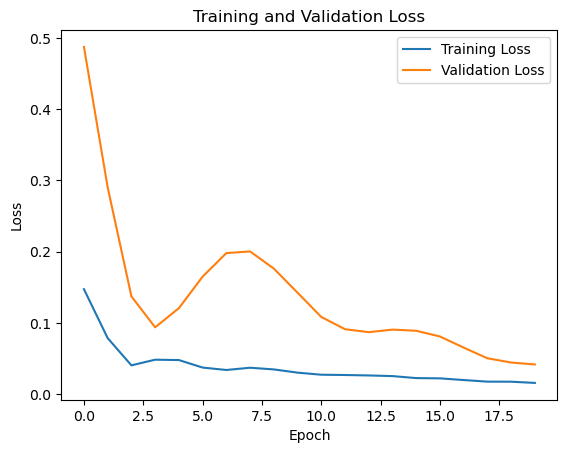

In [25]:
# Plot training and validation loss curves
def loss_curves(train_loss_history, val_loss_history):
    """
    Plot the training and validation loss curves for model performance evaluation.
    
    Arguments:
    train_loss_history : list : A list of training loss values at each epoch.
    val_loss_history   : list : A list of validation loss values at each epoch
    """
    
    # Plot training loss curve
    plt.plot(train_loss_history, label='Training Loss')

    # Plot validation loss curve
    plt.plot(val_loss_history, label='Validation Loss')

    # Add labels and title for the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Display legend to differentiate between training and validation loss
    plt.legend()

    # Display the plot
    plt.show()


# TODO: Plot the training and validation loss curves
loss_curves(train_loss_history, val_loss_history)

# Model Evaluation and Performance Visualization

In [ ]:
# Evaluation Function
def evaluate_model(model, test_loader, device, scaler):
    """
    Evaluate the model performance using the test dataset.

    Parameters:
    - model: The trained model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - device: The device (CPU or GPU) to run the model on.
    - scaler: The scaler used to transform the data (to inverse scale predictions).

    Returns:
    - rmse: The Root Mean Squared Error of the model predictions.
    - true_values: The true values from the test dataset (in original scale).
    - predicted_values: The predicted values from the model (in original scale).
    """
    model.eval()  # Set the model to evaluation mode
    true_values = []         # List to store true values
    predicted_values = []    # List to store predicted values

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            true_values.append(targets)
            predicted_values.append(outputs)

    true_values = torch.cat(true_values, dim=0).cpu().numpy()
    predicted_values = torch.cat(predicted_values, dim=0).cpu().numpy()

    # TODO: Inverse transform the true and predicted values to their original scale
    true_values = scaler.inverse_transform(true_values.reshape(-1, 1))
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))

    # TODO: Compute the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

    return rmse, true_values, predicted_values


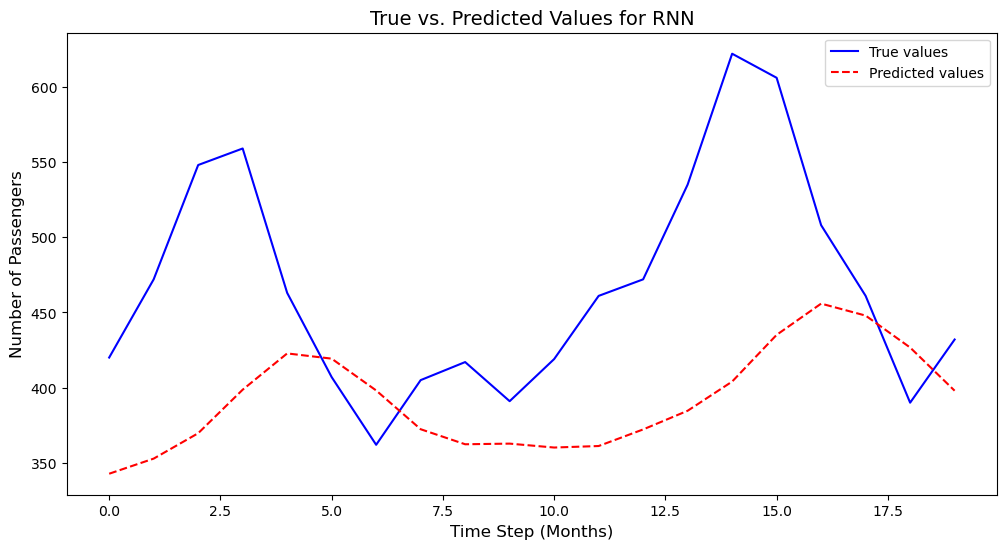

In [26]:
# Plot true values vs. predictions for the RNN model
def plot_true_pred(rnn_true, rnn_pred):    
    """
    Plots the true values against the predicted values for visual comparison.
    Args:
        rnn_true (numpy array): The actual target values from the test set.
        rnn_pred (numpy array): The predicted values generated by the model.
    """
    # Set the figure size for better visualization
    plt.figure(figsize=(12, 6))
    
    # Plot the true values
    plt.plot(rnn_true, label='True values', color='blue', linestyle='-')
    
    # Plot the predicted values
    plt.plot(rnn_pred, label='Predicted values', color='red', linestyle='--')
    
    # Add title and labels
    plt.title('True vs. Predicted Values for RNN', fontsize=14)
    plt.xlabel('Time Step (Months)', fontsize=12)
    plt.ylabel('Number of Passengers', fontsize=12)
    
    # Show the legend for better understanding
    plt.legend()
    
    # Display the plot
    plt.show()


# Evaluate the RNN model on test data and get the true values and predictions
rnn_rmse, rnn_true, rnn_pred = evaluate_model(rnn_model, test_loader, device, scaler)

# Plot the true vs. predicted values
plot_true_pred(rnn_true, rnn_pred)

In this cell, we evaluate the performance of the trained model across different data subsets (training, validation, and test). We use the `evaluate_model` function to compute the RMSE (Root Mean Squared Error) for each part.

By plotting the true values vs predictions for the training, validation, and test datasets, we can visually inspect how well the model performs on each part. Vertical lines are added to demonstrate the boundaries between the training, validation, and test data.

**Question:**

What do you expect to see in terms of the RMSE and the model’s performance on each dataset? How can you interpret the plot with respect to overfitting or underfitting?

**Training RMSE**: Typically lowest, since the model is optimized directly on this data.

**Validation RMSE**: Should be slightly higher than training RMSE. If it’s significantly higher, the model might be overfitting.

**Test RMSE**: Ideally, similar to validation RMSE. If it’s much worse, the model might not generalize well.

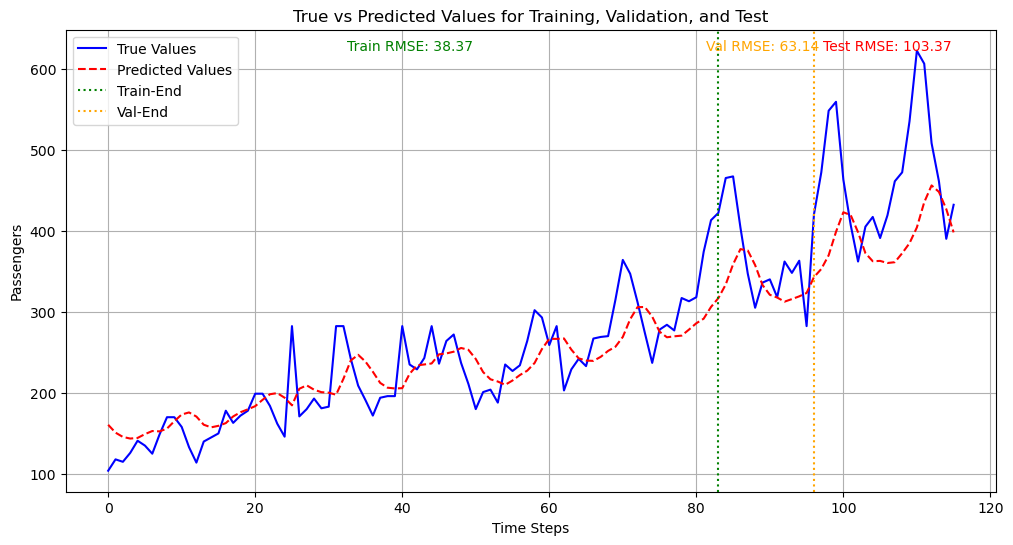

In [27]:
# Evaluate on each part: train, validation, and test
def evaluate_and_plot_with_rmse(model, train_loader, val_loader, test_loader, device, scaler):
    """
    This function evaluates the trained model on the training, validation, and test sets.
    It then concatenates the true and predicted values, and plots them along with RMSE values 
    for each part (train, validation, and test).
    """
    
    # Evaluate on training data
    train_rmse, train_true, train_pred = evaluate_model(model, train_loader, device, scaler)
    
    # Evaluate on validation data
    val_rmse, val_true, val_pred = evaluate_model(model, val_loader, device, scaler)
    
    # Evaluate on test data
    test_rmse, test_true, test_pred = evaluate_model(model, test_loader, device, scaler)
    
    # Concatenate the true values and predicted values from all parts
    all_true = np.concatenate([train_true, val_true, test_true])
    all_pred = np.concatenate([train_pred, val_pred, test_pred])
    
    # Plotting setup
    plt.figure(figsize=(12, 6))
    
    # Plot true values vs predicted values (blue for true, red for predicted)
    plt.plot(all_true, label='True Values', color='blue')
    plt.plot(all_pred, label='Predicted Values', color='red', linestyle='--')

    # Add vertical lines to indicate the boundaries between train, validation, and test parts
    train_end = len(train_true)
    val_end = train_end + len(val_true)
    
    # Vertical lines separating train, validation, and test
    plt.axvline(x=train_end, color='green', linestyle=':', label='Train-End')
    plt.axvline(x=val_end, color='orange', linestyle=':', label='Val-End')
    
    # Display RMSE values for each section (train, val, test)
    plt.text(train_end // 2, max(all_true), f'Train RMSE: {train_rmse:.2f}', color='green', fontsize=10, ha='center')
    plt.text((train_end + val_end) // 2, max(all_true), f'Val RMSE: {val_rmse:.2f}', color='orange', fontsize=10, ha='center')
    plt.text((val_end + len(all_true)) // 2, max(all_true), f'Test RMSE: {test_rmse:.2f}', color='red', fontsize=10, ha='center')
    
    # Customize the plot (title, labels, legend, etc.)
    plt.title("True vs Predicted Values for Training, Validation, and Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Passengers")
    plt.legend(loc='best')
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Set up train DataLoader with shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# Call the function to evaluate and plot
evaluate_and_plot_with_rmse(rnn_model, train_loader, val_loader, test_loader, device, scaler)

# Compare the RNN RMSE with GRU

In this section, we will compare the performance of the RNN model with the GRU (Gated Recurrent Unit) model on the same dataset. We will evaluate both models using the Root Mean Squared Error (RMSE) and visualize the results.

The GRU is a more advanced variant of the RNN, designed to address some of the issues that vanilla RNNs face, such as vanishing gradients. We expect the GRU to potentially perform better in certain cases, especially when the sequence length is long or the dataset is complex.

By comparing the RMSE for both models (RNN and GRU), we can better understand how each model performs on the task at hand and which one is more suitable for time-series prediction.

## Define the GRU Model

In [28]:
# Define GRU Model for Time Series Regression
class GRUModel(nn.Module):
    """
    A Gated Recurrent Unit (GRU) model for time series regression.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out


## Train & Evaluate

In [42]:
# Initialize the GRU model
gru_model = GRUModel(input_size=X_train.shape[2], hidden_size=50, num_layers=1, output_size=1)

# Train the GRU model
gru_train_loss, gru_val_loss = train_model(
    gru_model,
    train_loader,
    val_loader=val_loader,
    epochs=20,
    learning_rate=0.01,
    device=device,
    patience=10
)
# Evaluate the GRU model on the test set
gru_rmse, gru_true, gru_pred = evaluate_model(gru_model, test_loader, device, scaler)

# Print RMSE for GRU
print(f'GRU RMSE: {gru_rmse:.4f}')


Epoch [1/20], Train Loss: 0.0405, Validation Loss: 0.0532
Epoch [2/20], Train Loss: 0.1644, Validation Loss: 0.1849
Epoch [3/20], Train Loss: 0.0689, Validation Loss: 0.3231
Epoch [4/20], Train Loss: 0.0708, Validation Loss: 0.3015
Epoch [5/20], Train Loss: 0.0543, Validation Loss: 0.2133
Epoch [6/20], Train Loss: 0.0326, Validation Loss: 0.1099
Epoch [7/20], Train Loss: 0.0261, Validation Loss: 0.0505
Epoch [8/20], Train Loss: 0.0358, Validation Loss: 0.0457
Epoch [9/20], Train Loss: 0.0336, Validation Loss: 0.0642
Epoch [10/20], Train Loss: 0.0281, Validation Loss: 0.0812
Epoch [11/20], Train Loss: 0.0254, Validation Loss: 0.0787
Epoch [12/20], Train Loss: 0.0217, Validation Loss: 0.0581
Epoch [13/20], Train Loss: 0.0175, Validation Loss: 0.0357
Epoch [14/20], Train Loss: 0.0162, Validation Loss: 0.0260
Epoch [15/20], Train Loss: 0.0161, Validation Loss: 0.0249
Epoch [16/20], Train Loss: 0.0142, Validation Loss: 0.0254
Epoch [17/20], Train Loss: 0.0129, Validation Loss: 0.0247
Epoch 

## GRU vs RNN

In [43]:
print("\n--- Model Comparison ---")
print(f"RNN RMSE: {rnn_rmse:.4f}")
print(f"GRU RMSE: {gru_rmse:.4f}")


--- Model Comparison ---
RNN RMSE: 103.3693
GRU RMSE: 58.9321


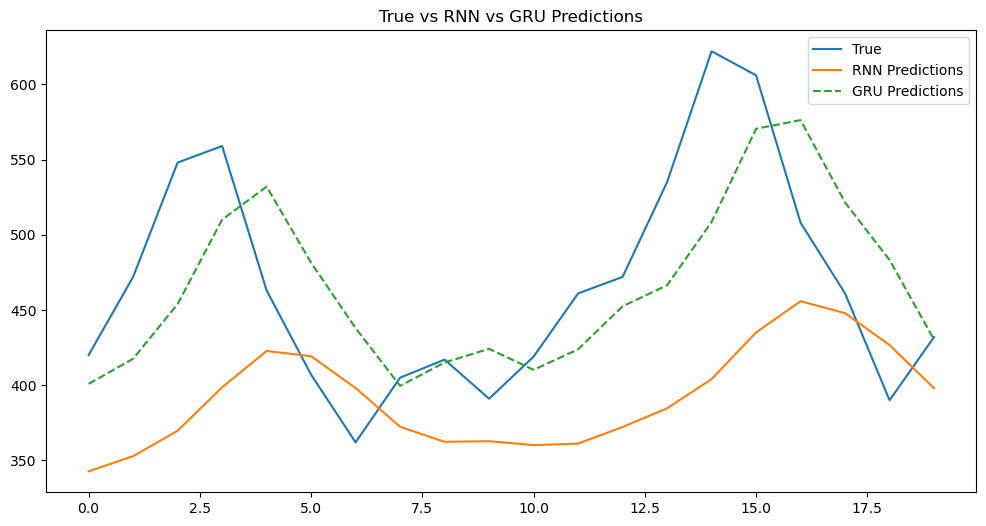

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(rnn_true, label='True')
plt.plot(rnn_pred, label='RNN Predictions')
plt.plot(gru_pred, label='GRU Predictions', linestyle='--')
plt.legend()
plt.title('True vs RNN vs GRU Predictions')
plt.show()


`RNN RMSE: 103.37`

`GRU RMSE: 58.93`

The GRU reduces RMSE by ~44%, which is a substantial improvement. In regression problems like this, a lower RMSE directly translates to more accurate predictions on average — so GRU is much better at capturing temporal patterns in your data.